In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt
import scipy

# Load Data

In [2]:
def get_data(ticker,start,end):
    data = yf.Ticker(ticker).history(start=start, end=end)
    data.index=pd.to_datetime(data.index.date) #reindex removing hours
    return data

In [29]:
data=get_data(ticker='GOOG', start='2024-01-01', end='2024-12-01')
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
2024-01-02,139.100199,140.111564,137.246857,139.060333,20071900,0.0,0.0
2024-01-03,138.103790,140.584865,137.934385,139.857483,18974300,0.0,0.0
2024-01-04,139.349293,140.131471,137.515870,137.545761,18253300,0.0,0.0
2024-01-05,137.856679,138.313031,136.360057,136.898117,15433200,0.0,0.0
2024-01-08,137.505915,140.136462,137.386349,140.026855,17645300,0.0,0.0


# Candlestick charts

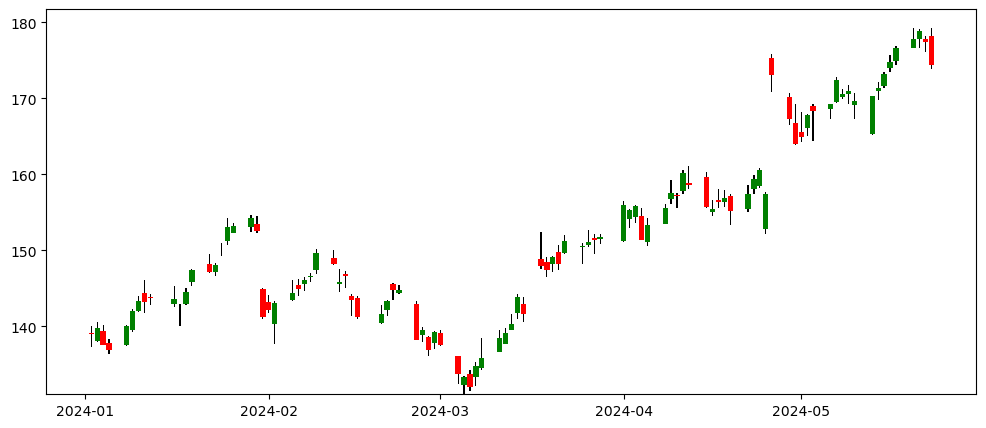

In [39]:
def plot_candlestick(data):
    '''data in OHLC format'''

    fig,ax=plt.subplots(figsize=(12,5))
    
    close_open_diff=data.Close-data.Open
    green_idx=close_open_diff[close_open_diff>=0].index
    red_idx  =close_open_diff[close_open_diff<0].index
    
    
    plt.bar(green_idx,
            height=(data.High-data.Low)[green_idx],
            bottom=data.Low[green_idx],
            width=0.2, color='k')
    plt.bar(green_idx,
            height=(data.Close-data.Open)[green_idx],
            bottom=data.Open[green_idx],
            width=0.9, color='g')
    
    
    plt.bar(red_idx,
            height=(data.High-data.Low)[red_idx],
            bottom=data.Low[red_idx],
            width=0.2, color='k')
    plt.bar(red_idx,
            height=(data.Close-data.Open)[red_idx],
            bottom=data.Open[red_idx],
            width=0.9, color='r')

plot_candlestick(data.iloc[:100,:])

# Support and Resistance

This method defines support and resistance levels using peak detection with scipy.signal.find_peaks function.

In [5]:
def resistance(data, num_levels):
    find_peaks=scipy.signal.find_peaks(data,prominence=(None,None),width=(None,None))
    peaks_idx = find_peaks[0]
    peaks_proms = find_peaks[1]['prominences']

    prom_sort_idx = peaks_idx[np.argsort(-peaks_proms)][:num_levels]
    prom_sort_vals= data.iloc[prom_sort_idx]
    prom_sort_dates=data.index[prom_sort_idx]

    ##midpoints=pd.qcut(prominence_sorted_val,q=70).apply(lambda x: x.mid)
    
    res=pd.DataFrame(index=data.index,dtype=float)
    for i in range(num_levels):
        res['resistance_{}'.format(i+1)]=np.nan
        res.loc[prom_sort_vals.sort_index().index[i]:,
                'resistance_{}'.format(i+1)]=\
                prom_sort_vals.sort_index().iloc[i]
    #return res
    return prom_sort_vals.values

def support(data,num_levels):
    return -resistance(-data,num_levels)

In [7]:
n_levels=2

train_size=int(len(data)*0.5)
train = data.iloc[:train_size] #Supp and Res levels are calculated based on the train data
test  = data.iloc[train_size:] #results are applied on the test data

supports=support(train.Low,n_levels)
resistances=resistance(train.High,n_levels)

sars=np.concatenate([supports,resistances]) #mix support and resistance levels

delta=0.01

In [8]:

def get_sar_orders(data,sars):
    df=pd.DataFrame(data.Close)
    df['action']=0
    for line in sars:
        for t in range(len(data.Close)-1):
            
            #expect bounce (reversal) on support, therefore buy
            if df.Close.iloc[t]<=line*(1+delta) and df.Close.iloc[t]>=line*(1-delta) and df.Close.iloc[t+1] > df.Close.iloc[t]:
                df.iloc[t+1,1]=1
        
            #if support is broken (outside tolerance interval), expect continuation, therefore sell
            if df.Close.iloc[t]>=line*(1-delta) and df.Close.iloc[t+1] <= line*(1-delta):
                df.iloc[t+1,1]=-1
            
            #expect bounce (reversal) on resistance, therefore sell
            if df.Close.iloc[t]>=line*(1-delta) and df.Close.iloc[t]<=line*(1+delta) and df.Close.iloc[t+1] < df.Close.iloc[t]:
                df.iloc[t+1,1]=-1
        
            #if resistance is broken (outside tolerance interval), expect continuation, therefore buy
            if df.Close.iloc[t]<=line*(1+delta) and df.Close.iloc[t+1] >= line*(1+delta):
                df.iloc[t+1,1]=1
    
            #make sure the signal to buy/sell is only given once:
            if len(df.action.iloc[:t+1][df.action!=0])>=2 and\
            df.action.iloc[:t+1][df.action!=0].iloc[-1]==df.action.iloc[:t+1][df.action!=0].iloc[-2]:
                df.iloc[t,1]=0
    return df

In [9]:
df=get_sar_orders(data,sars)
df['pos']     = df.action.replace(to_replace=0).ffill()
df['log_day_ret'] = np.log(df.Close/df.Close.shift(1))
df['cum_ret'] = np.exp(df.log_day_ret.cumsum())
df['str_cum_ret'] = np.exp((df.pos.shift(1)*df.log_day_ret).cumsum())
df.head()

/var/folders/vh/wpw67kkj0n5flm1swlm_yfth0000gp/T/ipykernel_14379/4282837015.py:2: FutureWarning: Series.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  df['pos']     = df.action.replace(to_replace=0).ffill()


,Close,action,pos,log_day_ret,cum_ret,str_cum_ret
2024-01-02,139.060333,0,0,NaN,NaN,NaN
2024-01-03,139.857483,0,0,0.005716,1.005732,1.000000
2024-01-04,137.545761,0,0,-0.016667,0.989109,1.000000
2024-01-05,136.898117,-1,-1,-0.004720,0.984451,1.000000
2024-01-08,140.026855,1,1,0.022597,1.006950,0.977656


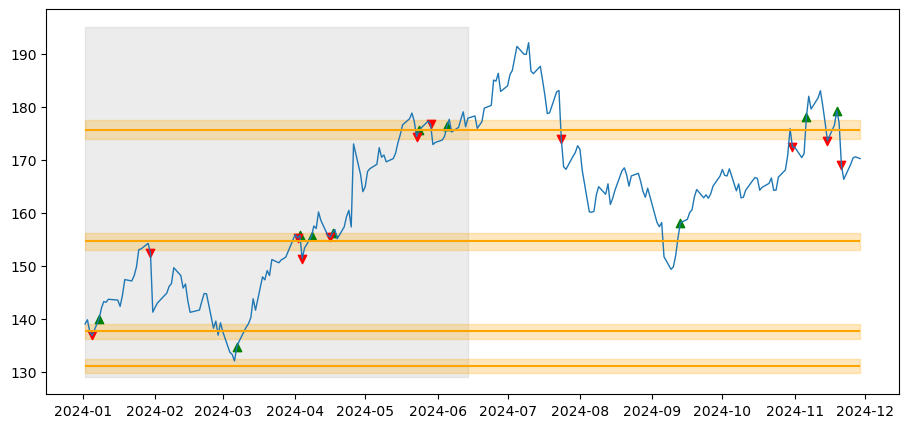

In [10]:
plt.figure(figsize=(11,5))
plt.plot(df.Close,lw=1)
plt.fill_between(x=train.index,   y1=plt.ylim()[0], y2=plt.ylim()[1],   color='grey',alpha=0.15)

for line in sars:
    plt.hlines(line, xmin=data.Close.index[0], xmax=data.Close.index[-1], color='orange')
    plt.fill_between(x=data.Close.index, y1=line*(1-delta),y2=line*(1+delta),color='orange',alpha=0.25)
    
plt.scatter(df[df.action==1].index,df[df.action==1].Close.values, marker='^',color='g')
plt.scatter(df[df.action==-1].index,df[df.action==-1].Close.values, marker='v',color='r')

The support and resistance levels are calculated on the left portion of the data (grey). Short/long positions are drawn in red/green triangles, and they are decided depending on how the price is approaching or leaving tolerance areas around the support or resistance levels.

# Patterns

In [24]:
def peaks(data,num_levels):
    find_peaks=scipy.signal.find_peaks(data,prominence=(None,None),width=(None,None))
    peaks_idx = find_peaks[0]
    peaks_proms = find_peaks[1]['prominences']

    idx = peaks_idx[np.argsort(-peaks_proms)][:num_levels]
    
    return data.iloc[idx].sort_index()
    
    #peaks=data.sort_values(ascending=False)[:3]
    #return peaks

    
def troughs(data,num_levels):
    return -peaks(-data,num_levels)

### Detecting Head & Shoulder Patterns

In [25]:
#Head & Shoulders


#t0,p1,t1,p2,t2,p3
def hs_extrema(prices):
    p=peaks(prices,3)
    
    #head condition: head higher than shoulders
    if len(p)>=3 and p.iloc[1] > np.max([p.iloc[0], p.iloc[2]]):

        #detect troughs between the shoulder and head
        t0=troughs(prices[:p.index[0]],1)
        t1=troughs(prices[p.index[0]:p.index[1]],1)
        t2=troughs(prices[p.index[1]:p.index[2]],1)
        t=pd.concat([t0,t1,t2])
       
        if len(t)>=3:

            #balance condition: each shoulder higher than half the other shoulder  
            if p.iloc[0]>=(p.iloc[2]+t.iloc[2])/2 and\
               p.iloc[2]>=(p.iloc[0]+t.iloc[0])/2 and\
               p.index[1]-p.index[0] < 2.5*(p.index[2]-p.index[1]) and\
               p.index[2]-p.index[1] < 2.5*(p.index[1]-p.index[0]):
                
                    return p,t
                #symmetry condition (on time axis): shoulder-head space less than 2.5 of the other side
    else:
        return None

def hs(prices):
        if hs_extrema(prices):
            p,t=hs_extrema(prices)
            shoulders_gap=(p.index[2]-p.index[0])
            check_confirmation=prices[p.index[2]:p.index[2]+shoulders_gap]
            
            coeff=(t.iloc[2]-t.iloc[1])/(t.index[2]-t.index[1]).days
            
            neckline=pd.Series(prices.loc[t.index[2]]+coeff*np.arange(0,len(prices[t.index[2]:])),
                      index=prices[t.index[2]:].index)
            
            bool_condition=check_confirmation<=neckline.reindex(check_confirmation.index)
            if bool_condition.any():
                return bool_condition[bool_condition==True].index[0]


def ihs(prices):
    return hs(-prices)
            

In [26]:
start = '2020-06-01'
end   = '2020-04-21'
shift = 10
window=90

def get_confirmation(start,length):
    points =[]
    results=[]
    series=[]
    for i in range(length):
        start_date=dt.datetime.strptime(start,"%Y-%m-%d")+dt.timedelta(i)
        end_date  =start_date+dt.timedelta(window)+dt.timedelta(i)
        #end_date=dt.datetime.strptime(end,"%Y-%m-%d")+dt.timedelta(i)
        data = yf.Ticker('GOOG').history(start=start_date, end=end_date)
        data.index=pd.to_datetime(data.index.date) #reindex removing hours
        prices=data.Close
        if hs(prices):
            results.append(hs(prices))
            points.append(hs_extrema(prices))
            series.append(prices)
    return results, points, series


In [28]:
fx=get_confirmation(start,19)

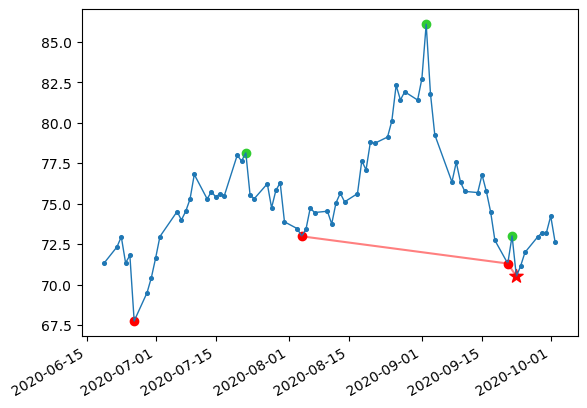

In [29]:
start_date = '2020-06-15'
end_date='2020-09-30'
data = yf.Ticker('GOOG').history(start=start_date, end=end_date)
data.index=pd.to_datetime(data.index.date) #reindex removing hours
prices=data.Close

def plot_hs(prices):
    
    p,t=hs_extrema(prices)
    
    prices.plot(lw=1)
    plt.scatter(prices.index,prices.values,s=7)
    plt.scatter(p.index,p.values,color='limegreen')
    plt.scatter(t.index,t.values,color='red')
    plt.plot([t.index[1],t.index[2]],[t.iloc[1],t.iloc[2]],color='red',alpha=0.5)
    plt.plot([t.index[2],hs(prices)],[t.iloc[2],prices[hs(prices)]],color='red',alpha=0.5)
    plt.scatter(hs(prices),prices[hs(prices)],color='red',marker='*',s=100)

plot_hs(fx[2][3])


The local maxima are drawn in green, local minima in red. Successful pattern confirmation happens when the price breaks through the red line, indicated with a star.

# Indicators

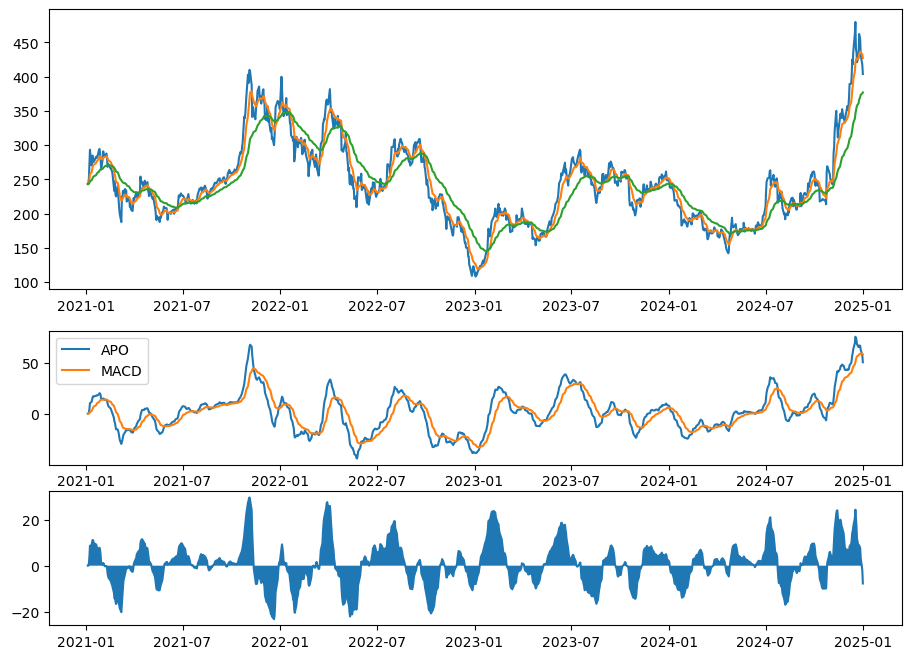

In [21]:
#=======================
#Exponential moving average (EMA)

def ema(data,alpha):
    ema_values=[]
    ema=0
    for price in data:
        if ema==0:
            ema=price
        else:
            #ema=alpha*(price-ema)+ema
            ema=alpha*price + (1-alpha)*ema
        ema_values.append(ema)
    ema=pd.Series(ema_values,index=data.index)
    return ema

#=======================
#Absolute price oscillator (EMA_fast-EMA_slow)

window_fast=10
alpha_fast=2/(window_fast+1)
window_slow=40
alpha_slow=2/(window_slow+1)

EMA_fast=ema(close, alpha_fast)
EMA_slow=ema(close, alpha_slow)
APO=EMA_fast-EMA_slow

#=======================
#Moving average convergence divergence
#it's an EMA of the APO

MACD_alpha=2/(20+1)
MACD_signal=ema(APO,MACD_alpha)


#Plots ==========
fig=plt.figure(figsize=(11,8))
ax1=fig.add_subplot(211)
ax1.plot(close)
ax1.plot(EMA_fast)
ax1.plot(EMA_slow)

ax2=fig.add_subplot(413)
ax2.plot(APO,label='APO')
ax2.plot(MACD_signal,label='MACD')
ax2.legend()

ax3=fig.add_subplot(414)
difference=APO-MACD_signal
ax3.plot(difference)
ax3.fill_between(difference.index,difference.values)
#ax3.plot(difference)

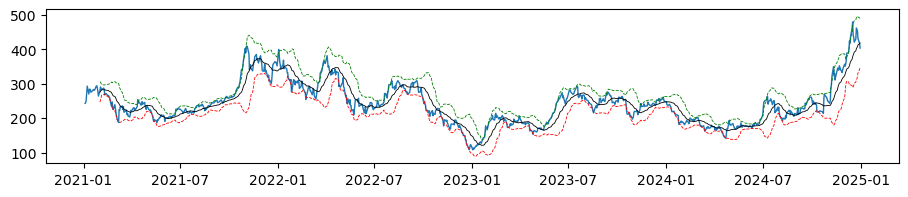

In [22]:
#Bollinger bands
#=======================
window=20
stds=2

SMA=close.rolling(window=window).mean()
moving_std=close.rolling(window=window).std()
upper_Boll=SMA+stds*moving_std
lower_Boll=SMA-stds*moving_std

fig=plt.figure(figsize=(11,2))
plt.plot(close, linewidth=1)
plt.plot(SMA, linewidth=0.6, c='k')
plt.plot(upper_Boll, '--', c='g',linewidth=0.6)
plt.plot(lower_Boll,'--', c='r', linewidth=0.6)

<Axes: >

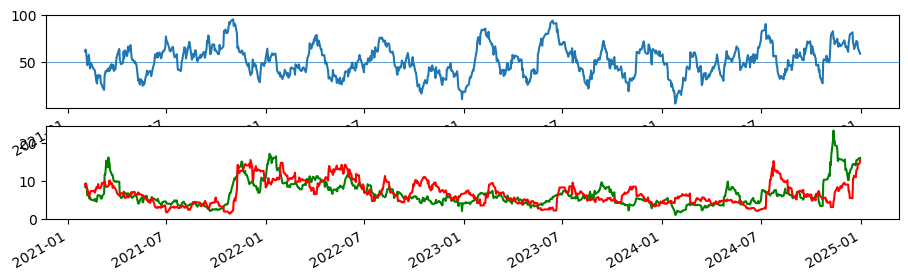

In [23]:
#Relative strength index (RSI)
#=======================

def gains(data):
    gains=data.diff()[data.diff()>=0]
    avg_gains=gains.mean()
    return avg_gains

def losses(data):
    losses=-data.diff()[data.diff()<0]
    avg_losses=losses.mean()
    return avg_losses

def rsi(data):
    gains=data.diff()[data.diff()>=0]
    losses=-data.diff()[data.diff()<0]
    RS=gains.sum()/losses.sum() #possible division by zero!
    RSI=100-(100/(1+RS))
    return RSI

fig,ax=plt.subplots(2,1,figsize=(11,3))
close.rolling(20).apply(rsi).plot(ax=ax[0])
ax[0].axhline(y=50,linewidth=0.5)
close.rolling(20).apply(gains).plot(ax=ax[1],color='g')
close.rolling(20).apply(losses).plot(color='red')